In [13]:
!pip install -q torch torchvision
!pip install -q segment-anything
!pip install -q opencv-python pillow tqdm numpy matplotlib
!pip install -q sam2
!pip install -q albumentations


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [20]:
import numpy as np
import cv2
import os
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
import glob

class SealParasiteInstanceDataset(Dataset):
    def __init__(self, img_dir, img_ids, patch_size=1024, stride=512, augment=True):
        self.patch_size = patch_size
        self.stride = stride
        self.augment = augment

        self.transforms = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomRotate90(p=0.5),
            A.RandomBrightnessContrast(p=0.3),
            A.GaussianBlur(p=0.2),
            A.Normalize(),
        ]) if augment else A.Compose([A.Normalize()])

        self.samples = []
        for img_id in img_ids:
            img_paths = glob.glob(f"{img_dir}/{img_id}/*.JPG")
            mask_paths = glob.glob(f"{img_dir}/{img_id}/*_mask.npy")
            for img_path, mask_path in zip(sorted(img_paths), sorted(mask_paths)):
                self._index_instances(img_path, mask_path)

    def _index_instances(self, img_path, mask_path):
        mask = np.load(mask_path)
        h, w = mask.shape
        for y in range(0, h - self.patch_size + 1, self.stride):
            for x in range(0, w - self.patch_size + 1, self.stride):
                mask_patch = mask[y:y+self.patch_size, x:x+self.patch_size]
                instance_ids = np.unique(mask_patch)
                instance_ids = instance_ids[instance_ids > 0]
                for inst_id in instance_ids:
                    self.samples.append({
                        "img_path": img_path,
                        "mask_path": mask_path,
                        "x": x,
                        "y": y,
                        "instance_id": int(inst_id),
                    })

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        img = cv2.imread(sample["img_path"])[..., ::-1]
        mask = np.load(sample["mask_path"])

        x, y = sample["x"], sample["y"]
        img_patch = img[y:y+self.patch_size, x:x+self.patch_size]
        mask_patch = (mask[y:y+self.patch_size, x:x+self.patch_size] == sample["instance_id"]).astype(np.uint8)

        augmented = self.transforms(image=img_patch, mask=mask_patch)
        img_tensor = torch.from_numpy(augmented["image"]).permute(2, 0, 1).float()
        mask_tensor = torch.from_numpy(augmented["mask"]).unsqueeze(0).float()
        return img_tensor, mask_tensor


In [2]:
# Custom dataset split - FIXED ASSIGNMENT
output_dir = "Combined_Dataset"  # Your dataset directory

# Define the exact split
splits = {
    'train': ['B2025-00084n', 'B2025-00085e', 'B2025-00085k', 'B2025-00086a',
              'B2025-00130c', 'B2025-00130e', 'B2025-00137b', 'B2025-00137d',
              'B2025-00138b', 'B2025-00142a', 'B2025-00143b'],
    'val': ['B2025-00085.2', 'B2025-00136b'],
    'test': ['B2025-00130b', 'B2025-00139a', 'B2025-00139a-1']
}

print(f"Train: {len(splits['train'])} images")
print(f"Val:   {len(splits['val'])} images")
print(f"Test:  {len(splits['test'])} images")
print(f"\nTrain images: {splits['train']}")
print(f"Val images:   {splits['val']}")
print(f"Test images:  {splits['test']}")

Train: 11 images
Val:   2 images
Test:  3 images

Train images: ['B2025-00084n', 'B2025-00085e', 'B2025-00085k', 'B2025-00086a', 'B2025-00130c', 'B2025-00130e', 'B2025-00137b', 'B2025-00137d', 'B2025-00138b', 'B2025-00142a', 'B2025-00143b']
Val images:   ['B2025-00085.2', 'B2025-00136b']
Test images:  ['B2025-00130b', 'B2025-00139a', 'B2025-00139a-1']


In [ ]:
training_set = SealParasiteInstanceDataset("dataset2", splits["train"], augment=True)
validation_set = SealParasiteInstanceDataset("dataset2", splits["val"], augment=False)
test_set = SealParasiteInstanceDataset("dataset2", splits["test"], augment=False, stride=1024)

train_loader = DataLoader(training_set, batch_size=1, shuffle=True, num_workers=4, pin_memory=True)
validation_loader = DataLoader(validation_set, batch_size=1, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=5, shuffle=False, num_workers=1, pin_memory=True)

In [4]:
from segment_anything import sam_model_registry

sam_checkpoint = "sam_vit_b_01ec64.pth"
model_type = "vit_b"
device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device)

# Optionally enable LoRA tuning
from peft import get_peft_model, LoraConfig
config = LoraConfig(r=8, lora_alpha=32, target_modules=["attn.qkv", "attn.proj"])
sam = get_peft_model(sam, config)


In [6]:
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import torch.nn.functional as F

def sam_forward_logits(sam_model, images):
    image_embeddings = sam_model.image_encoder(images)
    sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(points=None, boxes=None, masks=None)
    low_res_masks, _ = sam_model.mask_decoder(
        image_embeddings=image_embeddings,
        image_pe=sam_model.prompt_encoder.get_dense_pe(),
        sparse_prompt_embeddings=sparse_embeddings,
        dense_prompt_embeddings=dense_embeddings,
        multimask_output=False,
    )
    return F.interpolate(low_res_masks, size=images.shape[-2:], mode="bilinear", align_corners=False)

def dice_loss(logits, targets, eps=1e-6):
    probs = torch.sigmoid(logits)
    num = 2 * (probs * targets).sum(dim=(2, 3))
    den = probs.sum(dim=(2, 3)) + targets.sum(dim=(2, 3)) + eps
    return 1 - (num / den).mean()

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(sam.parameters(), lr=1e-4)
num_epochs = 10
best_val_loss = float("inf")
best_ckpt_path = "sam_instance_best.pth"
final_ckpt_path = "sam_instance_final.pth"

for epoch in range(num_epochs):
    sam.train()
    total_loss = 0.0
    for imgs, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        imgs, masks = imgs.to(device), masks.to(device)
        preds = sam_forward_logits(sam, imgs)
        loss_bce = criterion(preds, masks)
        loss_dice = dice_loss(preds, masks)
        loss = loss_bce + loss_dice

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train = total_loss / len(train_loader)

    sam.eval()
    val_loss = 0.0
    with torch.no_grad():
        for imgs, masks in validation_loader:
            imgs, masks = imgs.to(device), masks.to(device)
            preds = sam_forward_logits(sam, imgs)
            loss_bce = criterion(preds, masks)
            loss_dice = dice_loss(preds, masks)
            val_loss += (loss_bce + loss_dice).item()

    avg_val = val_loss / len(validation_loader)
    if avg_val < best_val_loss:
        best_val_loss = avg_val
        torch.save(
            {"epoch": epoch + 1, "val_loss": avg_val, "model_state": sam.state_dict()},
            best_ckpt_path,
        )
        print(f"Saved best checkpoint to {best_ckpt_path}")
    print(f"Epoch {epoch+1}: train_loss={avg_train:.4f} | val_loss={avg_val:.4f}")

torch.save(
    {"epoch": num_epochs, "val_loss": avg_val, "model_state": sam.state_dict()},
    final_ckpt_path,
)
print(f"Saved final checkpoint to {final_ckpt_path}")


Epoch 1/10: 100%|██████████| 7313/7313 [27:17<00:00,  4.47it/s]


Saved best checkpoint to sam_instance_best.pth
Epoch 1: train_loss=0.9562 | val_loss=0.9717


Epoch 2/10: 100%|██████████| 7313/7313 [28:17<00:00,  4.31it/s]


Saved best checkpoint to sam_instance_best.pth
Epoch 2: train_loss=0.9516 | val_loss=0.9676


Epoch 3/10: 100%|██████████| 7313/7313 [28:26<00:00,  4.29it/s]


Saved best checkpoint to sam_instance_best.pth
Epoch 3: train_loss=0.9502 | val_loss=0.9663


Epoch 4/10: 100%|██████████| 7313/7313 [27:18<00:00,  4.46it/s]


Saved best checkpoint to sam_instance_best.pth
Epoch 4: train_loss=0.9489 | val_loss=0.9653


Epoch 5/10: 100%|██████████| 7313/7313 [27:03<00:00,  4.51it/s]


Epoch 5: train_loss=0.9485 | val_loss=0.9656


Epoch 6/10:   1%|          | 65/7313 [00:14<27:35,  4.38it/s] 


KeyboardInterrupt: 

5 in batch


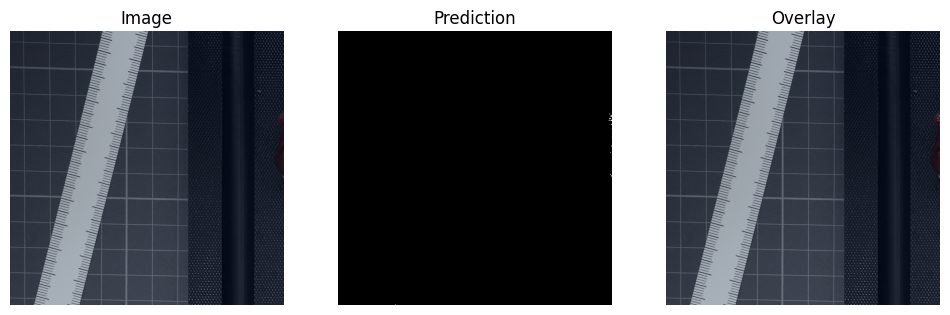

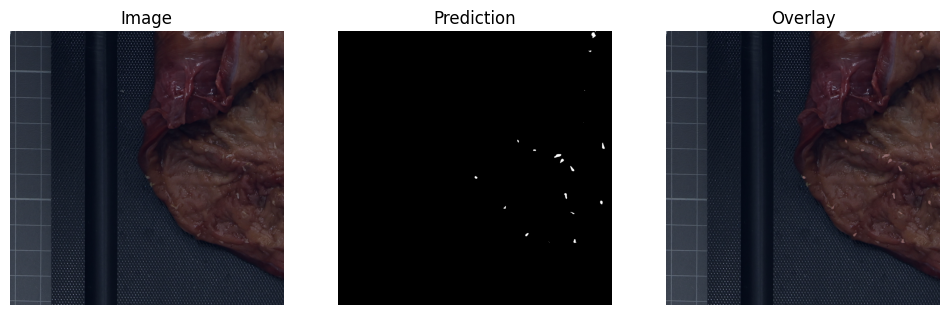

5 in batch
5 in batch
5 in batch
5 in batch


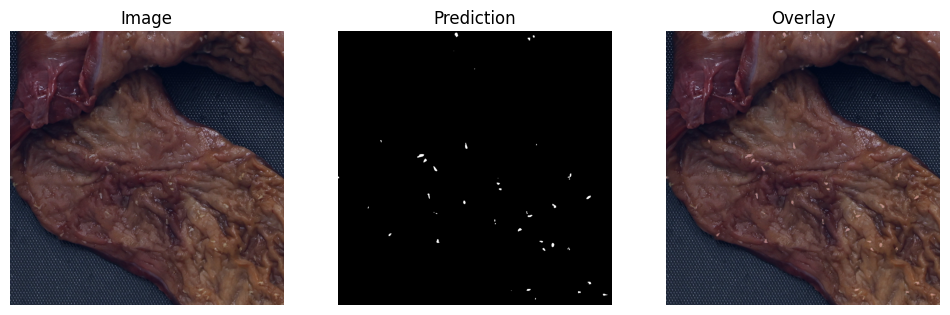

5 in batch
5 in batch
5 in batch
5 in batch
5 in batch
5 in batch
5 in batch
5 in batch
5 in batch


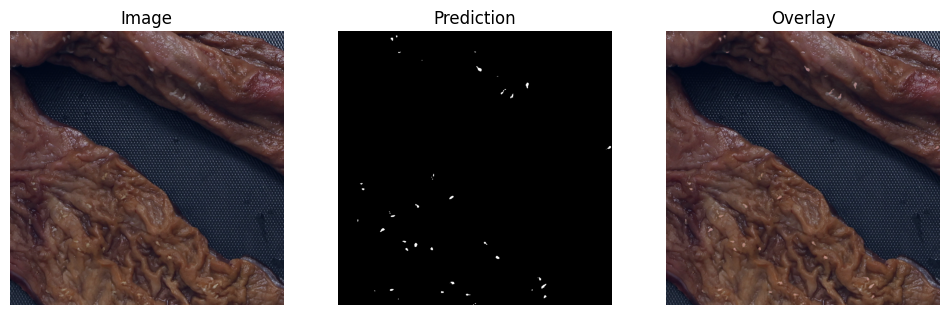

5 in batch
5 in batch
5 in batch
5 in batch
5 in batch
5 in batch
5 in batch
5 in batch


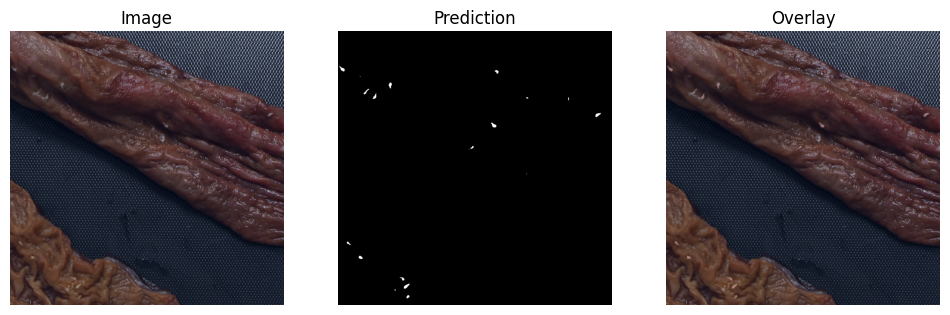

5 in batch
5 in batch


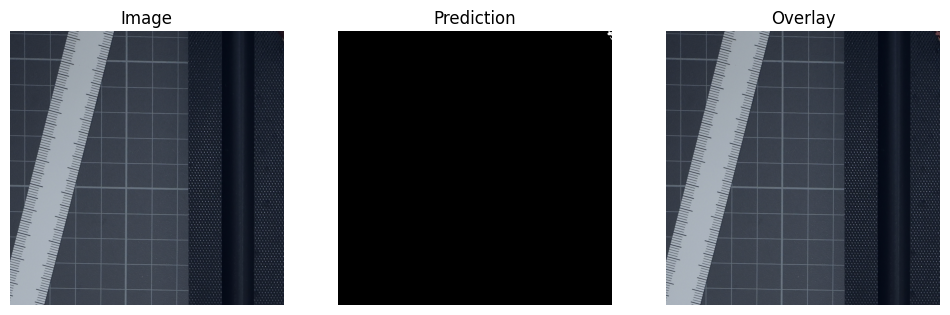

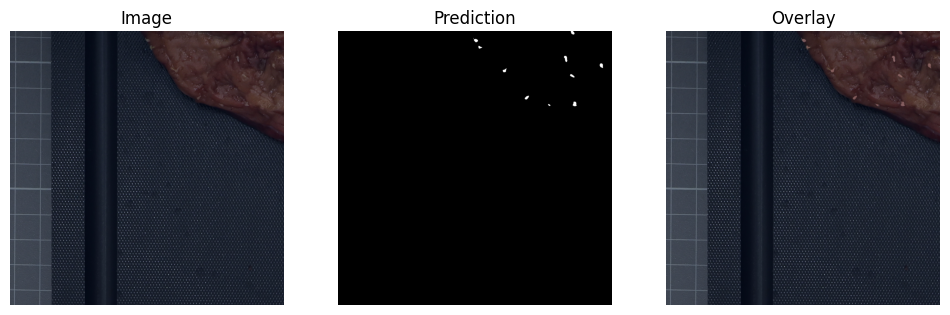

5 in batch
5 in batch


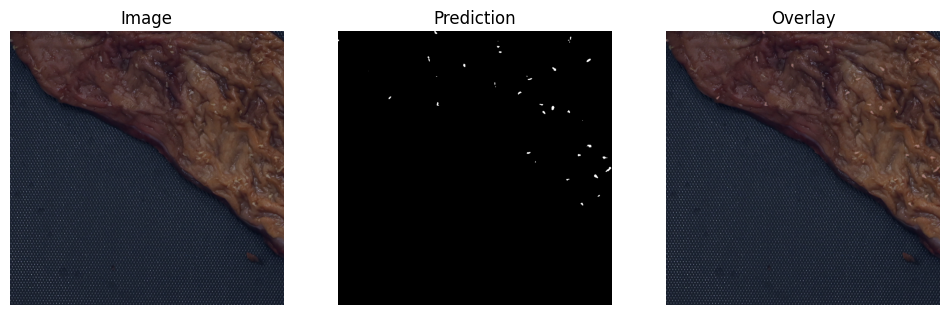

5 in batch
5 in batch
5 in batch
5 in batch
5 in batch
5 in batch
5 in batch
5 in batch
5 in batch


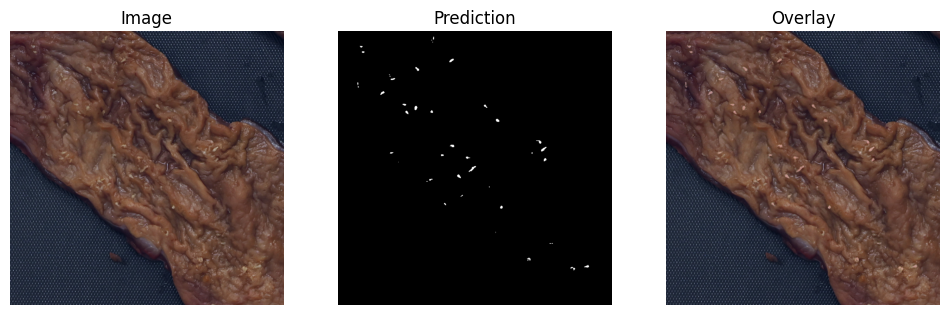

5 in batch
5 in batch
5 in batch
5 in batch
5 in batch
5 in batch
5 in batch
5 in batch
5 in batch
5 in batch
5 in batch
5 in batch


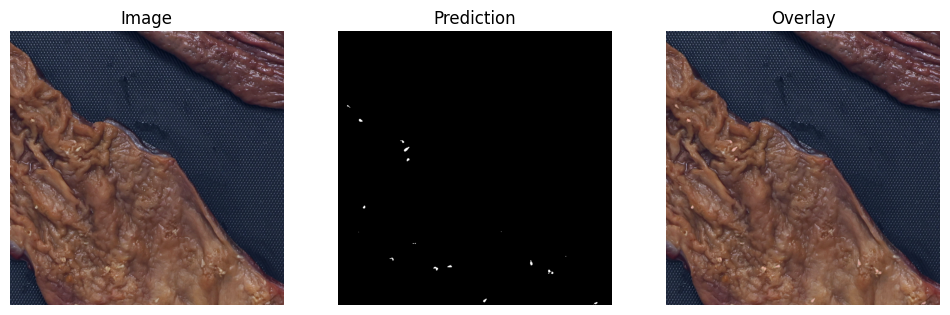

5 in batch
5 in batch
5 in batch
5 in batch
5 in batch
5 in batch
5 in batch


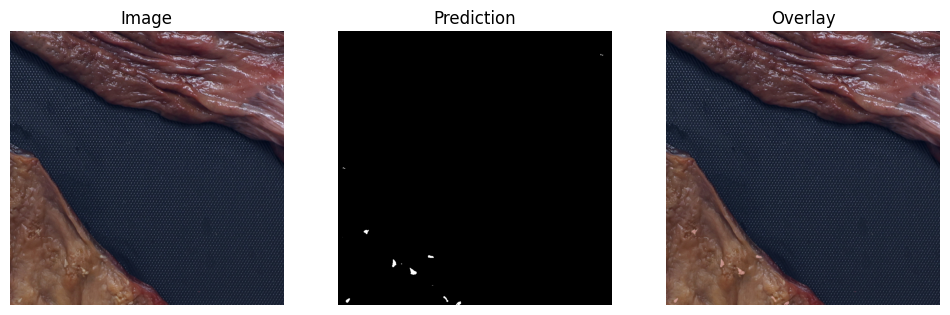

5 in batch
5 in batch
5 in batch


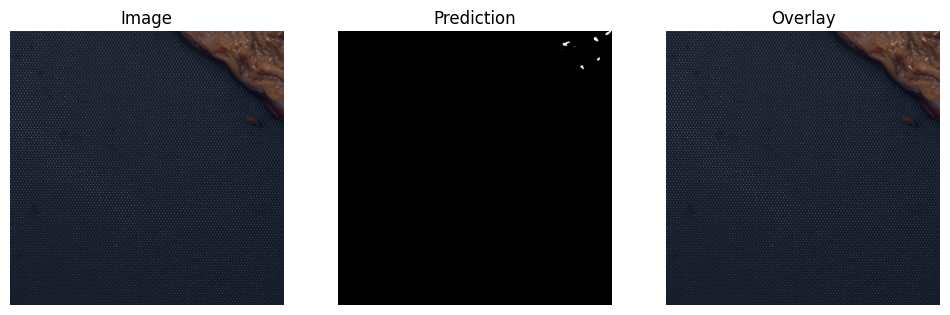

5 in batch
5 in batch


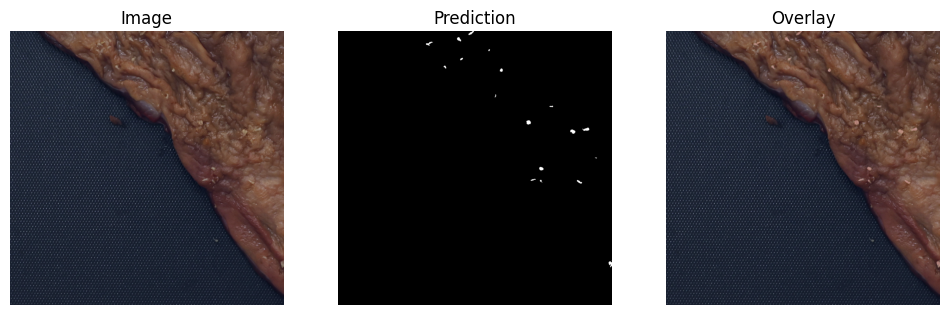

5 in batch
5 in batch
5 in batch
5 in batch
5 in batch
5 in batch
5 in batch


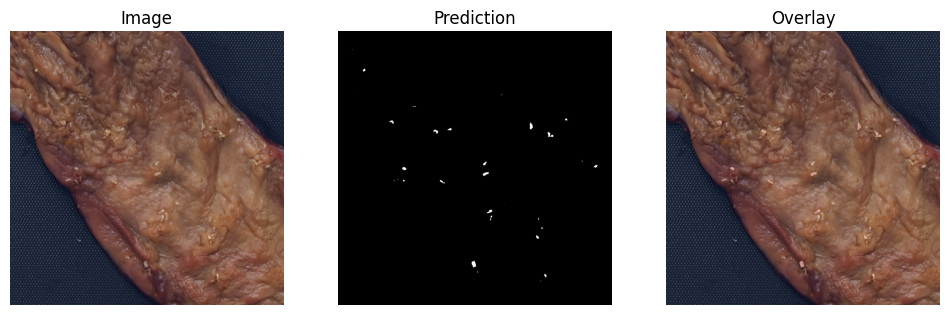

5 in batch
5 in batch
5 in batch
5 in batch
5 in batch
5 in batch
5 in batch
5 in batch
5 in batch


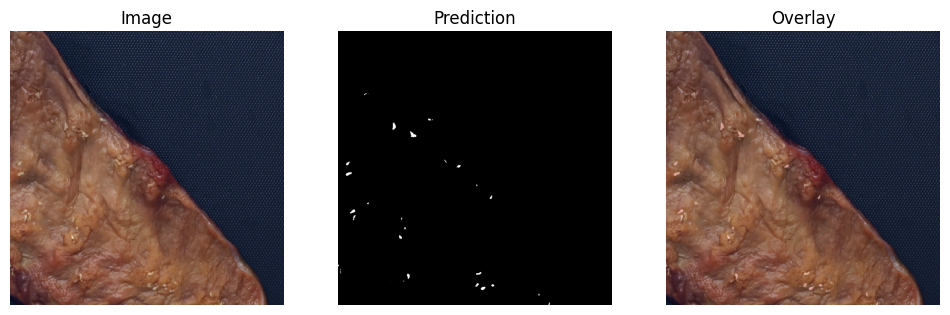

In [22]:

sam.load_state_dict(torch.load(best_ckpt_path)["model_state"])
sam.eval()

import matplotlib.pyplot as plt

def visualize_predictions(loader, limit=5):
    shown = 0
    last_img_sum = 0
    with torch.no_grad():
        for imgs, masks in loader:
            imgs = imgs.to(device)
            preds = torch.sigmoid(sam_forward_logits(sam, imgs)).cpu().numpy()
            imgs_np = imgs.cpu().numpy().transpose(0, 2, 3, 1)

            for img_np, pred in zip(imgs_np, preds):
                if img_np.sum() == last_img_sum:
                    continue
                last_img_sum = img_np.sum()
                mask = (pred[0] > 0.5).astype(np.uint8)
                overlay = img_np.copy()
                overlay[mask == 1] = overlay[mask == 1] * 0.5 + np.array([1, 0, 0]) * 0.5

                fig, axes = plt.subplots(1, 3, figsize=(12, 4))
                axes[0].imshow((img_np - img_np.min()) / (img_np.max() - img_np.min()))
                axes[0].set_title("Image")
                axes[1].imshow(mask, cmap="gray")
                axes[1].set_title("Prediction")
                axes[2].imshow((overlay - overlay.min()) / (overlay.max() - overlay.min()))
                axes[2].set_title("Overlay")
                for ax in axes:
                    ax.axis("off")
                plt.show()

                shown += 1
                if shown >= limit:
                    return

visualize_predictions(test_loader, limit=15)